# Calculation of receiver functions
In this notebook, we calculate a receiver function for a 3-component record of one event at a single station. It is a modification of the minimal example provided by Tom Eulenfeld (Richter) on Github.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from obspy.core import read, Stream, Trace, UTCDateTime
from obspy.taup import TauPyModel
from obspy import read_events
from obspy.signal.filter import lowpass
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = 15, 4

We first read the QuakeML file which contains information about the avaiable seismic events using ObsPy. We get a catalogue object whih can be iterated through events and from which information can be extracted. Here, we are interested in the origin time.

In [2]:
cat = read_events("example_events.xml")
for ev in cat:
    print(ev.origins[0].time)

2011-05-15T13:08:15.420000Z
2011-05-13T22:47:55.340000Z
2011-04-30T08:19:16.720000Z
2011-04-18T13:03:04.360000Z
2011-04-07T13:11:23.430000Z
2011-03-31T00:11:58.880000Z
2011-03-06T14:32:36.940000Z
2011-03-01T00:53:45.350000Z
2011-02-25T13:07:26.980000Z
2011-02-21T23:51:42.340000Z
2011-02-21T10:57:51.760000Z
2011-02-12T17:57:56.170000Z
2011-01-31T06:03:26.330000Z


In the minimal example by Tom Eulenfeld, data of the following three events are provided in the SAC format (a fairly widespread format used with SAC (seismological analysis code) software In the following cell, you can choose one of the three events by setting the variable "evnum".

In [18]:
evnum = 1                                              # coose an event (0,1,2)
avail_events = (cat[1],cat[6],cat[8])                  # pick available events from catalogue
event_dates = ("20110513","20110306","20110225")       # hack for reading associated SAC files
event = avail_events[evnum]                            # select an event
evdate = event_dates[evnum]
print(event.origins)

[Origin(resource_id=ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=9925460"), time=UTCDateTime(2011, 3, 6, 14, 32, 36, 940000), longitude=-27.0253, latitude=-56.3864, depth=92000.0, creation_info=CreationInfo(author='ISC'))]


Here, we read the SAC files, detrend and taper the data and then apply a bandpass filter. Afterwards, the traces are trimmed to a 90 seconds time window.

In [19]:
st = read("data/PB01.BH?."+evdate+".sac", format = "SAC")    # read data using ObsPy
st.detrend("linear")                                         # detrending
st.taper(0.05,type = "hann")                                 # tapering
st.filter('bandpass', freqmin=0.4, freqmax=1.0)              # bandpass filter
dt = st[0].stats.delta
for tr in st:                                                # trim to 90 s window
    ta = tr.stats.starttime
    tr.trim(ta+5.,ta+95.)

The "stats"-attribute of the data stream contains pretty much details about the traces and the event such as backazimuth, epicentral distance and other useful things.

         network: CX
         station: PB01
        location: 
         channel: BHE
       starttime: 2011-03-06T14:40:44.719539Z
         endtime: 2011-03-06T14:42:14.719539Z
   sampling_rate: 5.0
           delta: 0.2
            npts: 451
           calib: 1.0
         _format: SAC
      processing: ["ObsPy 1.1.0: detrend(options={}::type='linear')", "ObsPy 1.1.0: taper(max_length=None::max_percentage=0.05::side='both'::type='hann')", "ObsPy 1.1.0: filter(options={'freqmin': 0.4, 'freqmax': 1.0}::type='bandpass')", 'ObsPy 1.1.0: trim(endtime=UTCDateTime(2011, 3, 6, 14, 42, 14, 719539)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2011, 3, 6, 14, 40, 44, 719539))']
             sac: AttribDict({'delta': 0.2, 'depmin': -4753.0, 'depmax': 7559.0, 'scale': 1.0, 'b': 0.00053899997, 'e': 120.00054, 'o': -482.77899, 'stla': -21.04323, 'stlo': -69.487396, 'stel': 900.0, 'evla': -56.386398, 'evlo': -27.025299, 'evdp': 92.0, 'mag': 6.5, 'dist': 5242.6309, 'az': 300.

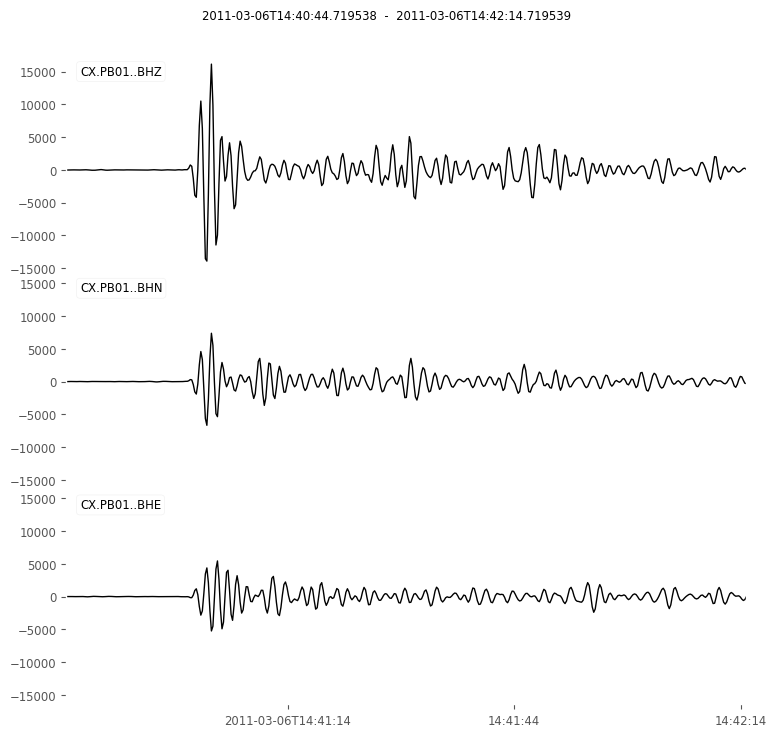

In [20]:
print(st[0].stats)
st.plot()

Next, we rotate the ZNE-components into the LQT-system. To do this, we need the backazimuth and the incidence angle of the P-wave. Both are not perfectly known but can be estimated assuming the P-wave propagates in the plane of the source-receiver great circle and using a standard earth model to calculate travel time and incidence angle. The obspy.taup module helps us with this task. 

In [21]:
model = TauPyModel(model="iasp91")              # create a model object for ray tracing
evdep = st[0].stats.sac["evdp"]                 # extract event depth from trace stats
epidis = st[0].stats.sac["gcarc"]               # extract epicentral distance in degrees from trace stats
baz = tr.stats.sac["baz"]                       # extract backazimuth from trace stats
arrivals = model.get_travel_times(              # get travel time, incidence angle stored in arrivals-object
    source_depth_in_km = evdep,distance_in_degree=epidis,phase_list="P")
incl = arrivals[0].incident_angle               # extract incidence angle
ttime = arrivals[0].time                        # extract arrival time
st.rotate('ZNE->LQT',back_azimuth=baz, inclination=incl)     # rotate components

3 Trace(s) in Stream:
CX.PB01..BHT | 2011-03-06T14:40:44.719539Z - 2011-03-06T14:42:14.719539Z | 5.0 Hz, 451 samples
CX.PB01..BHQ | 2011-03-06T14:40:44.719538Z - 2011-03-06T14:42:14.719538Z | 5.0 Hz, 451 samples
CX.PB01..BHL | 2011-03-06T14:40:44.719539Z - 2011-03-06T14:42:14.719539Z | 5.0 Hz, 451 samples

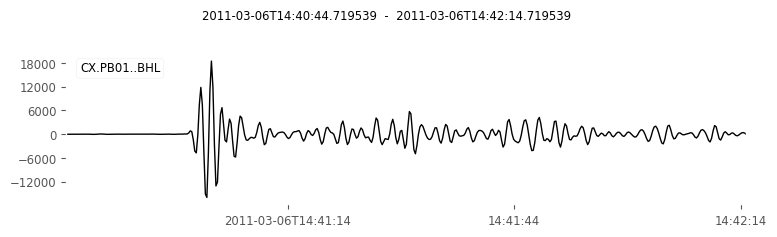

In [22]:
st[2].plot()             # plot new L-component

Next, we trim the traces to a 40 s window around the P-onset which we estimate by adding the travel time to the event origin time. We could also pick the arrival time. The resulting trace is again tapered to avoid artifacts in the discrete Fourier transform.

2011-03-06T14:40:59.816249Z
3 Trace(s) in Stream:
CX.PB01..BHT | 2011-03-06T14:40:49.719539Z - 2011-03-06T14:41:29.719539Z | 5.0 Hz, 201 samples
CX.PB01..BHQ | 2011-03-06T14:40:49.719538Z - 2011-03-06T14:41:29.719538Z | 5.0 Hz, 201 samples
CX.PB01..BHL | 2011-03-06T14:40:49.719539Z - 2011-03-06T14:41:29.719539Z | 5.0 Hz, 201 samples


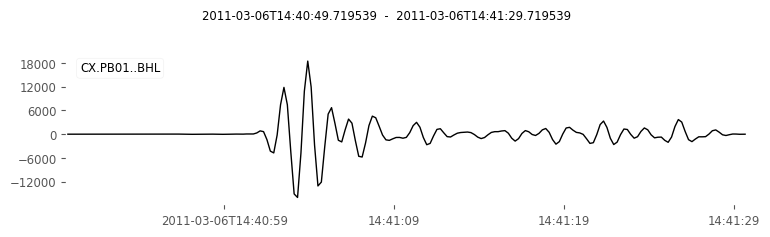

In [23]:
onset = event.origins[0].time+ttime            # onset time = origin time + travel time
print(onset)
st.trim(onset-10.,onset+30.)
st.taper(0.125,type = "hann")
print(st)
st[2].plot()

In [24]:
zcomp = st[2].data                                    # rename traces
rcomp = st[1].data

## Deconvolution in the frequency domain using waterlevel method
Here comes the central routine for receiver function calculation which does the deconvolution, here using the water level method. Note that we add zeros to the traces to avoid the pitfalls when doing cross-correlation inthe frequency domain. We deconvolve both the Z- or L-component and the R-or Q-component.

In [25]:
def deconvWaterLevel(rsp, src, dt, waterlevel=0.05, alfa=2.,
                     tshift=None,length=None,normalize=False):
    """
    Frequency-domain deconvolution using waterlevel method.
    Deconvolve src from rsp.

    :param rsp: trace to be deconvolved (nominator)
    :param src: trace to deconvolved with (denominator)
    :param dt: sampling interval of data
    :param waterlevel: waterlevel to stabilize the deconvolution
    :param gauss: Gauss parameter of low-pass filter
    :param tshift: shift zero lag of receiver function to the right by tshift
    :param length: number of data points in results, optional
    :param normalize: normalize to src (default = False)
    :return: receiver function
    """
    npts = len(rsp)
    if length == None:
        nout = npts
    else:
        nout = length                                        # cut output to nout samples
    nfft = int(pow(2, np.ceil(np.log(npts)/np.log(2))))      # next higher power of 2
    nfft = 2*nfft                                            # add zeros to avoid pitfalls with cc 
    freq = np.fft.rfftfreq(nfft,dt)                          # Fourier frequencies
    spq = np.fft.rfft(rsp,nfft)                              # FT of R or Q component
    spz = np.fft.rfft(src,nfft)                              # FT of Z or L component
    spshift = np.exp(-1j*2.*np.pi*freq*tshift)               # time shift (applied in the frequency domain)
    cspz = np.conjugate(spz)                                 # complex conjugate needed later
    spzabs2 = np.abs(spz)**2                                 # absolute value squared
    water = np.maximum(spzabs2,max(spzabs2)*waterlevel)      # regularized denominator
    gauss = np.exp((-np.pi*freq/alfa)**2)                    # Gaussian low-pass filter
    sprfz = gauss*spshift*spzabs2/water                      # deconvolve Z or L component   
    rfz = np.fft.irfft(sprfz,nfft)[:npts]                    # Z or L receiver function intime domain
    if normalize:
        norm = 1.0/max(rfz)
    else:
        norm = 1.0
    rfz = norm*rfz                                           # normalize Z-receiver function to max of 1
    sprfq = gauss*spshift*spq*cspz/water                     # spectrum of Q-receiver function
    rfq = -np.fft.irfft(sprfq,nfft)*norm                     # Q-receiver function (normalized and sign reversed)
    return rfq[0:nout],rfz[0:nout]

In [26]:
tshift = 5.                                                  # shift the zero lag to +5 seconds
rfq,rfl = deconvWaterLevel(rcomp, zcomp, dt, 
                waterlevel=0.05, alfa=20.,
                length=150,tshift=tshift,normalize=True)     # do the deconvolution
tr = np.arange(0,len(rfq))*dt-tshift                         # take shift into account when plotting time axis

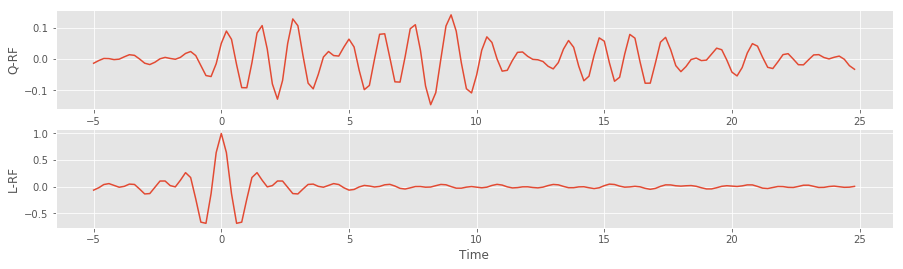

In [27]:
plt.subplot(211)
plt.plot(tr,rfq)
plt.ylabel("Q-RF")
plt.subplot(212)
plt.plot(tr,rfl)
plt.xlabel("Time")
plt.ylabel("L-RF")
plt.show()

## Deconvolution in the time domain using Wiener filter
Now, we do the deconvolution in the time domain using the Wiener filter method. We need the cross-correlation and the autocorrelation to form the Toeplitz matrix and the right hand side of the equation system.

In [28]:
p = len(zcomp)                                        # length of z and r
czr = np.correlate(rcomp,zcomp,mode = "full")         # correlation of z with r according to our definition
azz = np.correlate(zcomp,zcomp,mode = "full")         # auto-correlation of z
q = len(czr)                                          # length of correlations = 2*p-1
jc = q//2                                             # center of autocorrelation sits at j=q//2 = p-1
print("length of z:   ",p)
print("length of czr: ",q)
print("Center of correlation: ",jc)

length of z:    201
length of czr:  401
Center of correlation:  200


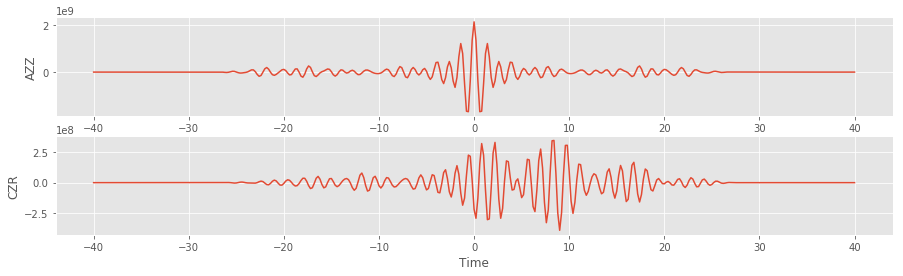

In [29]:
tm = np.arange(0,q)*dt-jc*dt                          # shift times for plotting
plt.subplot(211)
plt.xlabel("Time")
plt.ylabel("AZZ")
plt.plot(tm,azz)
plt.subplot(212)
plt.plot(tm,czr)
plt.xlabel("Time")
plt.ylabel("CZR")
plt.show()

In [30]:
m = 150                                                 # length of receiver function with m <= p
toeplmat = np.zeros((m,m))
for i in range(0,m):
    for j in range(0,m): 
        toeplmat[i,j] = azz[jc+i-j]                     # negative values of k-j are OK because we used "full"
        if j == i:
            toeplmat[i,j] = toeplmat[i,j]+0.05*azz[jc]  # regularization of solution
if m <= 4: 
    print(toeplmat)
rfq = -np.linalg.solve(toeplmat,czr[jc:jc+m])           # solve equation system for receiver function
rfl = np.linalg.solve(toeplmat,azz[jc:jc+m])            # solve for deconvolution of z with itself
rfl = lowpass(rfl,0.75,3,zerophase = True)              # low-pass filter result
rfq = lowpass(rfq,0.75,3,zerophase = True)
norm = np.max(rfl)
rfq = rfq/norm                                          # normalize result
rfl = rfl/norm

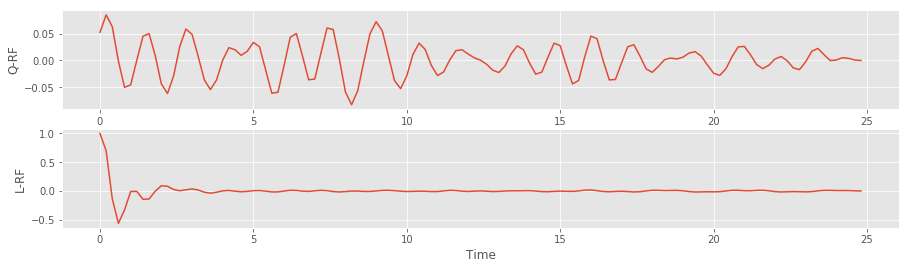

In [31]:
tm = np.arange(0,m)*dt                               # shift times for plotting
plt.subplot(211)
plt.plot(tm,rfq)
plt.ylabel("Q-RF")
plt.subplot(212)
plt.plot(tm,rfl)
plt.xlabel("Time")
plt.ylabel("L-RF")
plt.show()

## Iterative deconvolution
Finally, we try iterative deconvolution where the time of the conversions is determined experimentally by searching for maxima of the cross-correlation between radial and vertical component.

In [50]:
itmax = 1000                                          # stop after itmax iterations
eps = 0.1                                             # or if coeff less than eps
zcomp = st[2]                                         # rename traces
rcomp = st[1]
p = len(zcomp)                                        # length of z and r
it = 0                                                # start with iteration 0
rnew = rcomp[:]                                       # copy of radial component
norm = np.dot(rnew,rnew)                              # initial energy in radial component
zsh = np.zeros(p)                                     # shifted zcomp allocated here
a = np.zeros(itmax)                                   # space allocated for coefficients a
jmax = np.empty(itmax,dtype = int)                    # space allocated for conversion samples
while it < itmax:                                     # iteration loop
    czr = np.correlate(rnew,zcomp,mode = "full")         # correlation of z with r according to our definition
    jc = len(czr)//2                                     # positive lags start at j=q//2 = p-1
    jmax[it] = np.argmax(np.abs(czr[jc:]))               # location of absolute maximum of czr
    zsh[:] = 0.0                                         # zero shifted z(t)
    zsh[jmax[it]:] = zcomp[0:p-jmax[it]]                 # shifted z(t-tmax) cut at end
    a[it] = np.dot(rnew,zsh)/np.dot(zsh,zsh)             # compute coeficient
    rnew = rnew-a[it]*zsh                                # subtract shifted z(t-tmax) from radial component
    mf = np.sqrt(np.dot(rnew,rnew)/norm)                 # normalized residual amplitude in radial component
    if it%10 == 0:
        print("Iteration: ",it," Location of max correlation: ",jmax[it],
              " Coefficient: ",a[it]," RMS: ",mf)
    if abs(mf) < eps: break
    it = it+1

Iteration:  0  Location of max correlation:  45  Coefficient:  -0.188064932852  RMS:  0.808067884685
Iteration:  10  Location of max correlation:  56  Coefficient:  0.0232878399425  RMS:  0.236482738022
Iteration:  20  Location of max correlation:  26  Coefficient:  -0.0132327288213  RMS:  0.157940698442
Iteration:  30  Location of max correlation:  55  Coefficient:  0.00682842269855  RMS:  0.127478308995
Iteration:  40  Location of max correlation:  96  Coefficient:  -0.00547868539688  RMS:  0.113284892005
Iteration:  50  Location of max correlation:  117  Coefficient:  -0.00491286692813  RMS:  0.0989209837833
Iteration:  60  Location of max correlation:  45  Coefficient:  0.00363439542244  RMS:  0.0911542901353
Iteration:  70  Location of max correlation:  56  Coefficient:  0.00285406937047  RMS:  0.084300593319
Iteration:  80  Location of max correlation:  44  Coefficient:  0.00276115316265  RMS:  0.0791800623638
Iteration:  90  Location of max correlation:  45  Coefficient:  0.0022

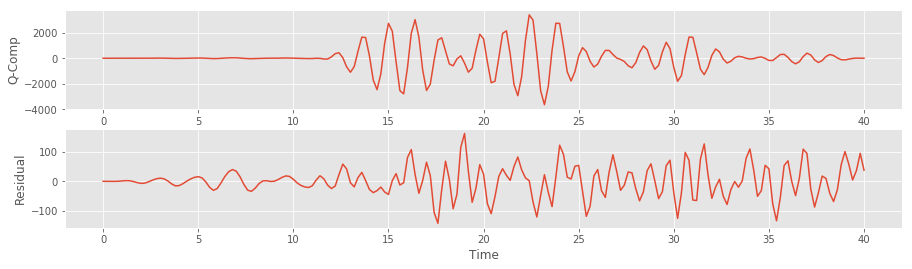

In [51]:
tm = np.arange(0,p)*dt
plt.subplot(211)
plt.plot(tm,rcomp)
plt.ylabel("Q-Comp")
plt.subplot(212)
plt.plot(tm,rnew)
plt.xlabel("Time")
plt.ylabel("Residual")
plt.show()

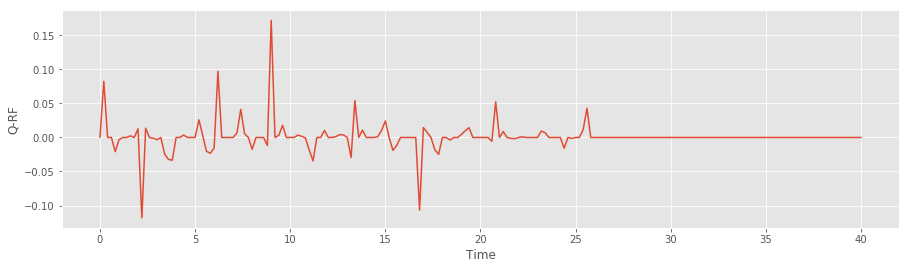

In [52]:
rfq = np.zeros(p)
for j,v in zip(jmax[0:it+1],a[0:it+1]):
    rfq[j] = rfq[j]-v
#rfq = lowpass(rfq,0.8,5,zerophase = True)
plt.plot(tm,rfq)
plt.xlabel("Time")
plt.ylabel("Q-RF")
plt.show()